In [2]:
_gender = 'Female'

In [3]:
import glob
import anndata
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from wmb import cemba
from scipy.stats import zscore
import numpy as np
import pathlib
import xarray as xr

In [4]:
# _class = 'Neu'
# mc_type = 'CHN'

#_class = 'NN'
mc_type = 'CGN'

In [5]:
pvalue_cutoff = 1e-6
top_n = 30
alpha_change = 0
min_gene_length = 2000

In [6]:
gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')

In [7]:
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [8]:
if _gender == 'Male':
    meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_mC_META.csv', index_col = 0)
    use_cts = joblib.load(f"/home/qzeng/project/aging/metadata/mc_use_cts")
elif _gender == 'Female':
    meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_m3C_META.csv', index_col = 0)
    use_cts = joblib.load(f"/home/qzeng/project/aging/metadata/m3c_use_cts")

In [9]:
data = xr.open_zarr(f'{mc_type}.{_gender}.AgingMajorType.Anova.Result.zarr')

In [10]:
all_pass_df = []
not_pass_df = []

for use_ct in use_cts:
    use_data = data.sel(cell_type = use_ct)
    anova_df = use_data['anova_results'].to_pandas()
    # filter gene_length
    anova_df['gene_length'] = anova_df.index.map(gene_length_dict)
    anova_df = anova_df[anova_df['gene_length'] > min_gene_length]
    anova_df['celltype'] = use_ct
    anova_df['methylation_change'] = anova_df['18mo'] - anova_df['8wk']
    anova_df['abs_change'] = abs(anova_df['methylation_change'])
    
    #filter trend 
    hyper_df = anova_df[(anova_df['18mo'] > anova_df['9mo']) & (anova_df['9mo'] >anova_df['8wk']) ]
    hypo_df = anova_df[(anova_df['18mo'] < anova_df['9mo']) & (anova_df['9mo'] <anova_df['8wk']) ]
    to_plot = pd.concat([hyper_df, hypo_df])
    to_plot['trend'] = to_plot['methylation_change'].apply(lambda x: 'Aging Hyper' if x >0 else 'Aging Hypo')
    
    # filter by pvalue and change
    pass_f_to_plot = to_plot[(to_plot['abs_change'] > alpha_change) & (to_plot['corrected_pvalue'] < pvalue_cutoff)]
    
    not_pass_f_to_plot =  anova_df.loc[list(set(pass_f_to_plot.index) ^ set(anova_df.index))]
    
    # filter for gene length
    
    assert (pass_f_to_plot.shape[0] + not_pass_f_to_plot.shape[0]) == anova_df.shape[0]
    
    all_pass_df.append(pass_f_to_plot)
    not_pass_df.append(not_pass_f_to_plot)
    
pass_f_to_plot = pd.concat(all_pass_df)
not_pass_f_to_plot = pd.concat(not_pass_df)

In [11]:
to_plot = pd.concat([pass_f_to_plot, not_pass_f_to_plot])

In [12]:
#to_plot.to_csv(f'result/{_gender}.{mc_type}.AllGene.Anova.Result.csv')

## plot

In [13]:
plot_celltypes_order = pass_f_to_plot['celltype'].value_counts().index
plot_celltypes_order = [ct for ct in plot_celltypes_order if ct.endswith('NN')] #

In [14]:
plot_celltypes_order = ['Oligo NN', 'OPC NN', 'Astro-TE NN', 'Astro-NT NN', 'Microglia NN']

In [15]:
# plot_celltypes_order = plot_celltypes_order[:10]
# len(plot_celltypes_order)

In [16]:
# order by dmg number
pass_f_to_plot = pass_f_to_plot[pass_f_to_plot['celltype'].isin(plot_celltypes_order)]

pass_f_to_plot.celltype = pd.Categorical(pass_f_to_plot.celltype, 
                      categories=plot_celltypes_order,
                      ordered=True)
pass_f_to_plot.sort_values('celltype', inplace=True)

In [17]:
to_annot_list = []
for ct, tmpdf in pass_f_to_plot.groupby('celltype'):
    tmpdf = tmpdf.sort_values('abs_change', ascending = False).head(3)
    to_annot_list.append(tmpdf)

to_annot = pd.concat(to_annot_list)
#to_annot = to_annot[to_annot['abs_change'] >= 0.1]
to_annot['gene_name'] = to_annot.index.map(gene_id_to_name)
to_annot.shape

(15, 11)

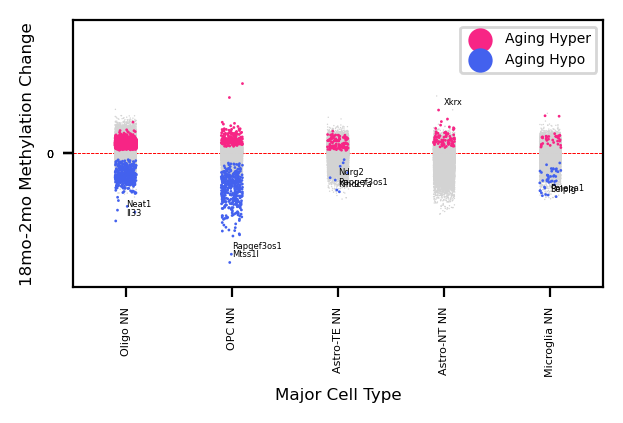

In [18]:
fig, ax = plt.subplots(figsize = (3,2), dpi = 200, constrained_layout = True)

cell_types = plot_celltypes_order
x = 'celltype'
y = 'methylation_change'
hue = 'trend'
kwargs = {'rasterized':True}

sns.stripplot(data=not_pass_f_to_plot, 
              x = x, y= y, 
              #legend=None,
              ax= ax, 
              size = 0.5,
              color = 'lightgrey',
              **kwargs)

p = sns.stripplot(data=pass_f_to_plot, 
              x = x, y= y, 
              #legend=True,
              hue = hue,
              ax= ax, 
              size = 1,
              palette=["#F72585", "#4361EE"],
              **kwargs)

##add text
for gene_id, row in to_annot.iterrows():
    s = row['gene_name']
    if s.startswith('Gm') or s.startswith(tuple('0123456789')):
        continue
    x = cell_types.index(row['celltype'])
    y = float(row['methylation_change'])
    ax.text(x = x, y=y +0.01, s=s,fontsize=3)  

#adjust_text(texts)

#ax.set_ylim(-1,1)
ax.set_ylabel('18mo-2mo Methylation Change', fontsize=6)
ax.set_xlabel('Major Cell Type', fontsize=6)

ax.set_yticks([-1,-alpha_change, 0,alpha_change, 1])
ax.tick_params(axis='x', labelrotation=90, labelsize=4)
ax.tick_params(axis='y', labelsize=4)

ax.axhline(y = -alpha_change, ls = '--', c = 'r', lw = '0.3')
ax.axhline(y = alpha_change, ls = '--', c = 'r', lw = '0.3')

p.legend(bbox_to_anchor = (1, 1), fontsize = 5)
ax.set_ylim(-0.25,0.25)
fig.savefig(f'figure/NN.{mc_type}.CellType.aDMG.pdf',  bbox_inches='tight')

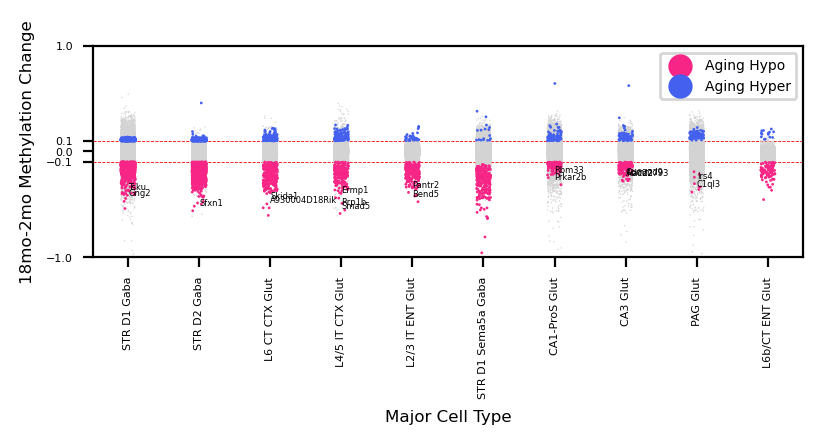

In [38]:
fig, ax = plt.subplots(figsize = (4,2), dpi = 200, constrained_layout = True)

cell_types = plot_celltypes_order
x = 'celltype'
y = 'methylation_change'
hue = 'trend'
kwargs = {'rasterized':True}

sns.stripplot(data=not_pass_f_to_plot, 
              x = x, y= y, 
              #legend=None,
              ax= ax, 
              size = 0.5,
              color = 'lightgrey',
              **kwargs)

p = sns.stripplot(data=pass_f_to_plot, 
              x = x, y= y, 
              #legend=True,
              hue = hue,
              ax= ax, 
              size = 1,
              palette=["#F72585", "#4361EE"],
              **kwargs)

##add text
for gene_id, row in to_annot.iterrows():
    s = row['gene_name']
    if s.startswith('Gm') or s.startswith(tuple('0123456789')):
        continue
    x = cell_types.index(row['celltype'])
    y = float(row['methylation_change'])
    ax.text(x = x, y=y+0.05, s=s,fontsize=3)  

#adjust_text(texts)

#ax.set_ylim(-1,1)
ax.set_ylabel('18mo-2mo Methylation Change', fontsize=6)
ax.set_xlabel('Major Cell Type', fontsize=6)

ax.set_yticks([-1,-alpha_change, 0,alpha_change, 1])
ax.tick_params(axis='x', labelrotation=90, labelsize=4)
ax.tick_params(axis='y', labelsize=4)

ax.axhline(y = -alpha_change, ls = '--', c = 'r', lw = '0.3')
ax.axhline(y = alpha_change, ls = '--', c = 'r', lw = '0.3')

p.legend(bbox_to_anchor = (1, 1), fontsize = 5)
ax.set_ylim(-1,1)
fig.savefig(f'figure/{_gender}.Selected.CellType.aDMG.pdf',  bbox_inches='tight')

### 